In [880]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Click me to hide code blocks</button>""", raw=True)

Click me to hide code blocks

# HappyDB Research 

by: Andy Huang

## Introduction

What makes your feel happy? HappyDB collects 100,000 happy moments from people. But the question is, does men and women experience happiness differently? Today, we are going to find an answer. Also, I would like to build models to predict the gender using data.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

<IPython.core.display.Javascript object>


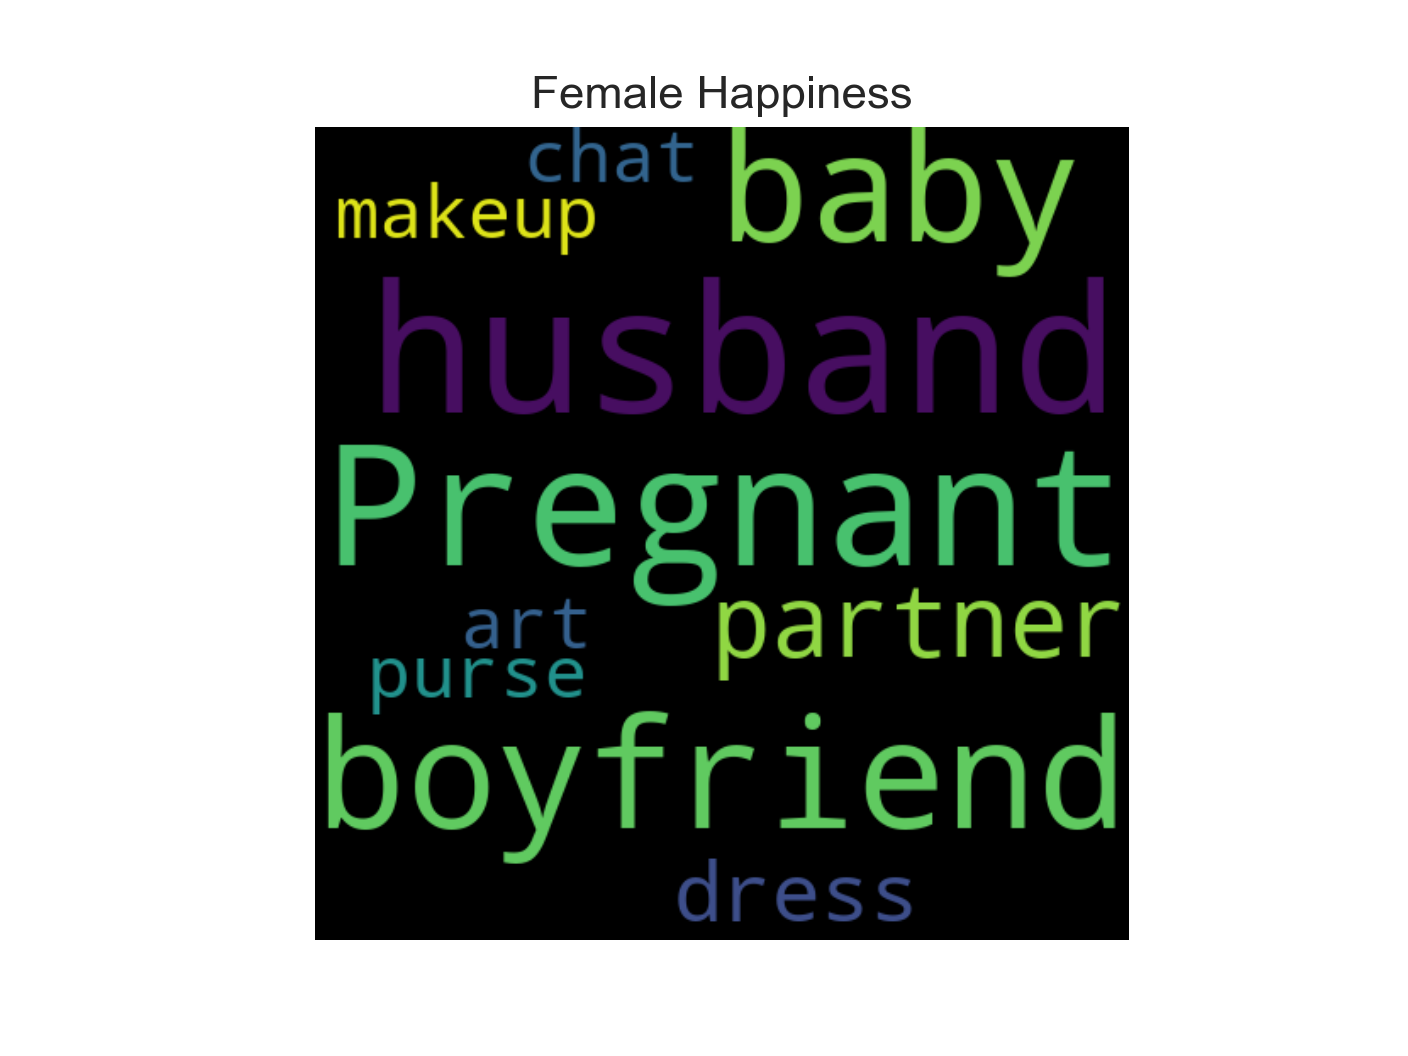

In [103]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
plt.figure()
# Create a list of word
text = ('''husband husband husband husband husband husband husband husband
boyfriend boyfriend boyfriend boyfriend boyfriend boyfriend boyfriend
Pregnant Pregnant Pregnant Pregnant Pregnant Pregnant Pregnant Pregnant 
baby baby baby baby baby baby baby 
partner partner partner partner partner partner 
dress dress dress dress 
makeup makeup makeup
art art art
purse purse purse
chat chat chat''')


 
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Female Happiness',fontsize = 15);

<IPython.core.display.Javascript object>


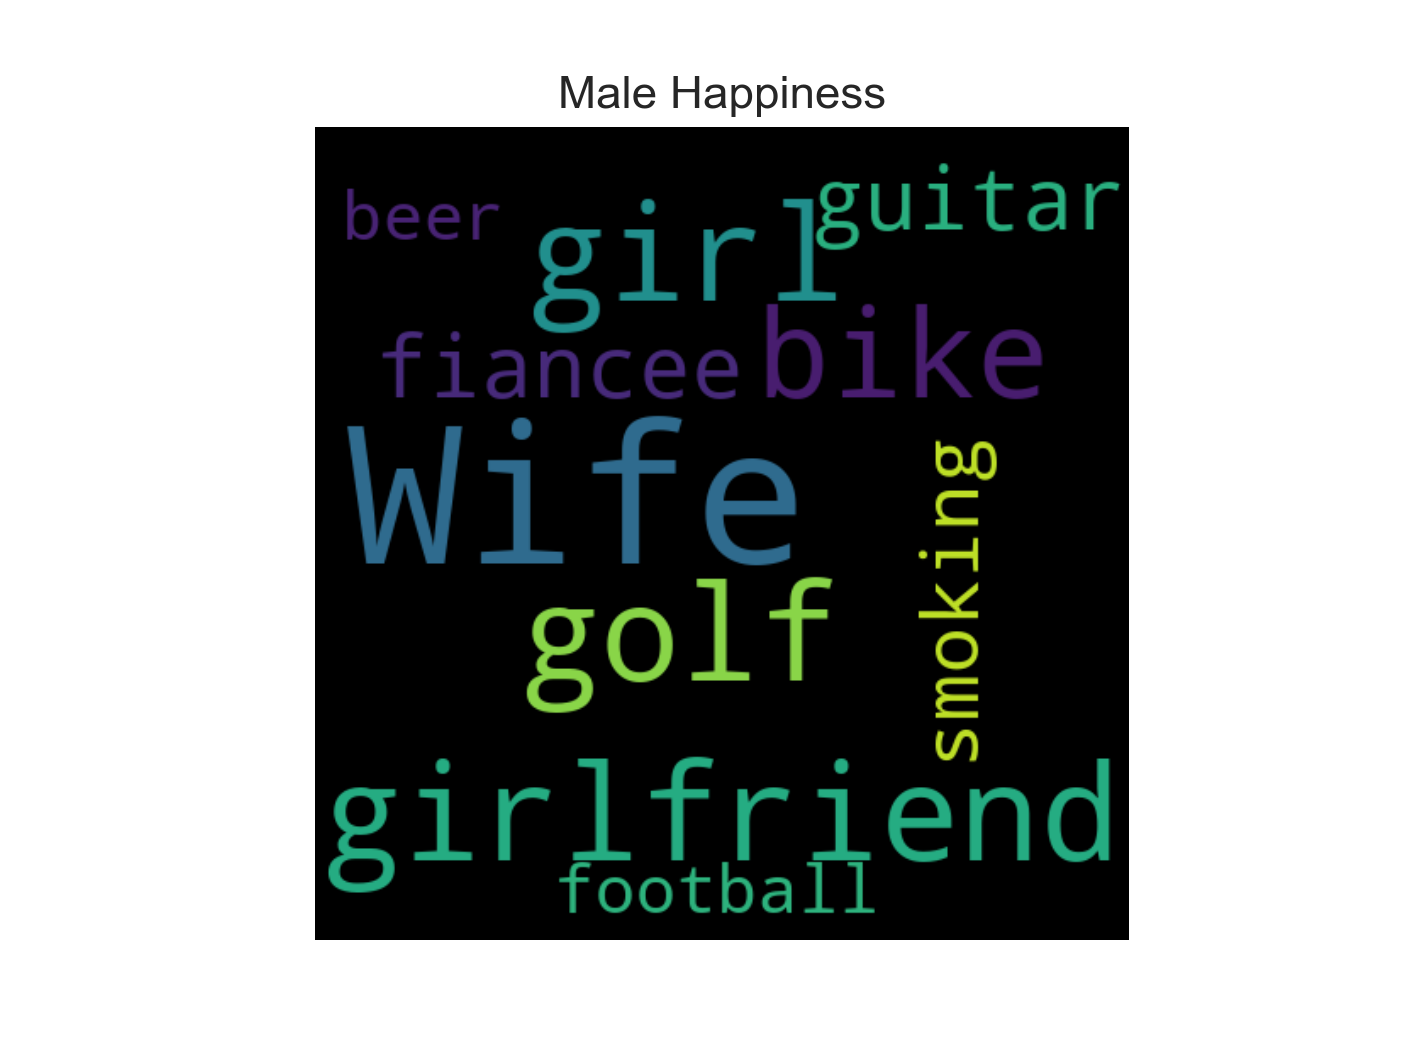

In [104]:
plt.figure()
text = ('''Wife Wife Wife Wife Wife Wife Wife Wife
girlfriend girlfriend girlfriend girlfriend girlfriend girlfriend girl girl girl girl girl girl
golf golf golf golf golf golf 
smoking smoking smoking smoking 
bike bike bike bike bike 
fiancee fiancee fiancee fiancee fiancee 
guitar guitar guitar guitar guitar 
beer beer beer 
football football football ''')


 
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Male Happiness',fontsize = 15);

In [105]:
hm = pd.read_csv('cleaned_hm.csv')
demographic = pd.read_csv('demographic.csv')
# merge 2 dataset
happy =  hm.merge(demographic, on = 'wid')

In [106]:
# clean age
def age_clean(age):
    try:
        return int(float(age))
    except:
        return -1
    

happy['age'] = happy['age'].apply(age_clean)
# drop the ages below 17 and beyong 100
happy = happy[(happy['age']>= 17) & (happy['age'] <= 100)]

# Only consider male & female
happy = happy[(happy['gender'] == 'm') | (happy['gender'] == 'f')]
# drop na of marital
happy = happy[happy['marital'].notnull()]
# drop na of parenthood
happy = happy[happy['parenthood'].notnull()]
# drop original_hm,modified and ground_truth_category (too many na)
happy = happy.drop(['original_hm','modified','ground_truth_category'],axis = 1)

## EDA

First, let's do some data preprocessing, I delete some outlier of the age column, and keep the age betwen 17 to 100. For gender, we only consider male and female. Then drop all NA value of our data.

Now, let's find out the gender distribution among our dataset.

In [107]:
import seaborn as sns

<IPython.core.display.Javascript object>


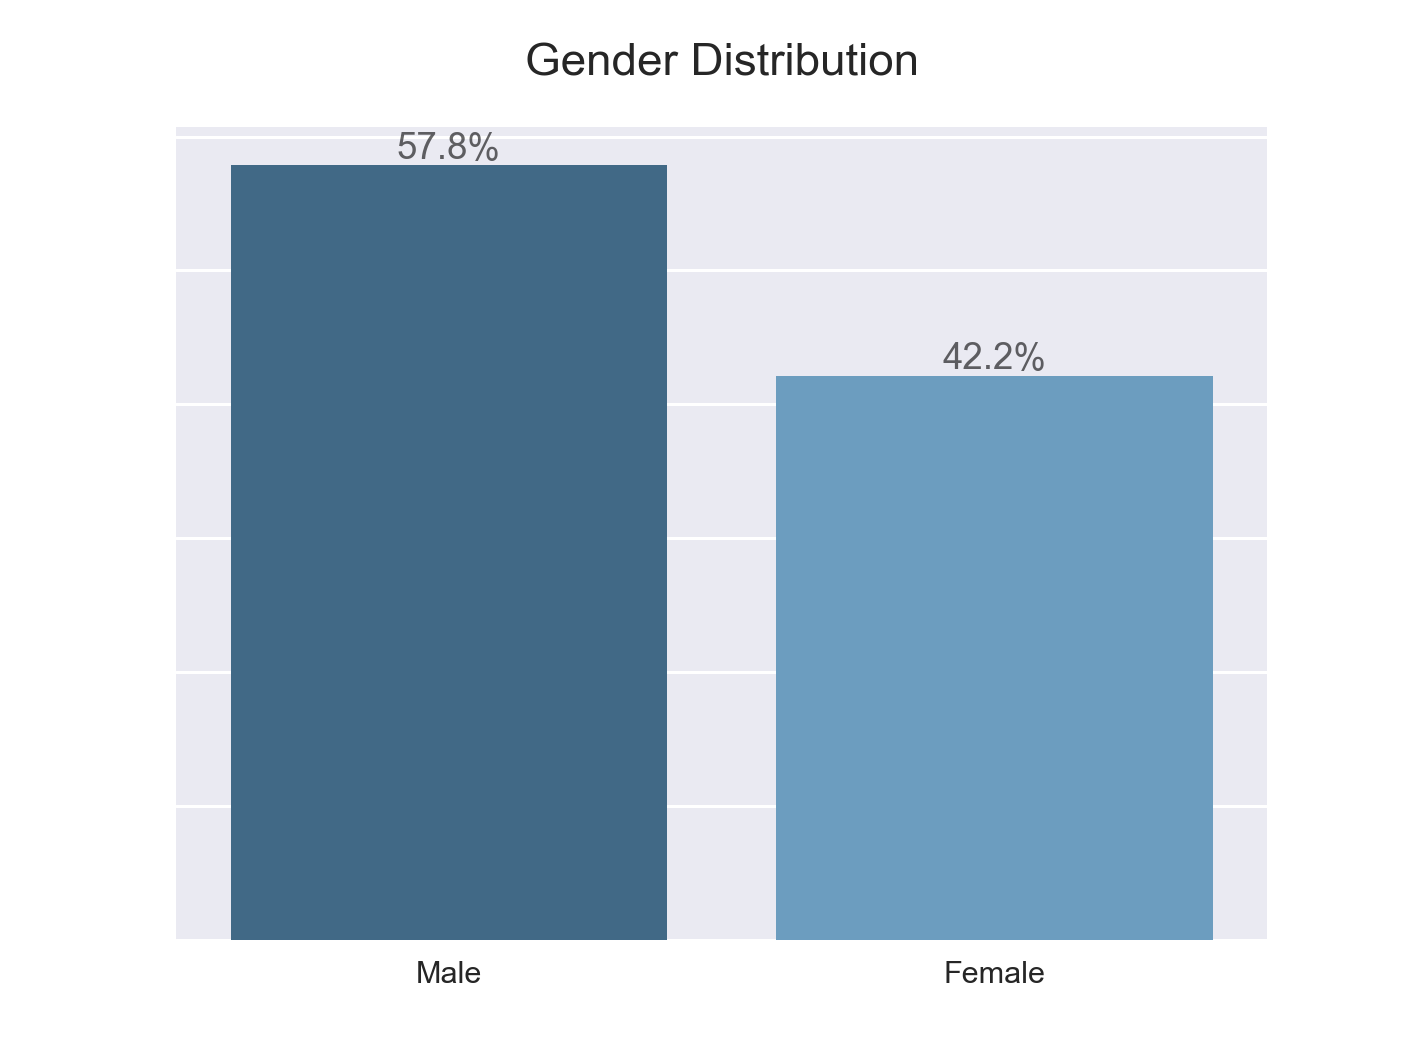

In [108]:
plt.figure()
g = (happy['gender'].value_counts()/happy.shape[0])
ax = sns.barplot(g.index,g,palette="Blues_d")
ax.set_xlabel('')
ax.set_xticklabels(['Male','Female'])
ax.set_yticklabels('')
ax.set_ylabel('')
ax.set_title('Gender Distribution',loc = 'center', fontsize = 15,y = 1.04)
for i,text in enumerate(g):
    ax.text(i,text+0.005,'{0:.1%}'.format(text),color = 'black',alpha = 0.6,ha="center")

We can see there are around 58% of people are male, and 42% are female. So our data is a little unbalanced. In addition, the distribution also tell us, if we randomly choose a person from the dataset and predict the gender, there are 58% chance he is a male. So 58% can be a baseline for our model accuracy.

Let's plot the Predicted Category distribution.

In [109]:
happy['gender'] = np.where(happy['gender'] == 'm',1,0);


In [110]:
# plt.figure()
# g = (happy['reflection_period'].value_counts()/happy.shape[0])
# ax = sns.barplot(g.index,g,palette="Blues_d")
# ax.set_xlabel('')
# ax.set_yticklabels('')
# ax.set_ylabel('')
# ax.set_title('Reflection Period Distribution',loc = 'center', fontsize = 15,y = 1.04)
# for i,text in enumerate(g):
#     ax.text(i,text+0.005,'{0:.1%}'.format(text),color = 'black',alpha = 0.6,ha="center")

<IPython.core.display.Javascript object>


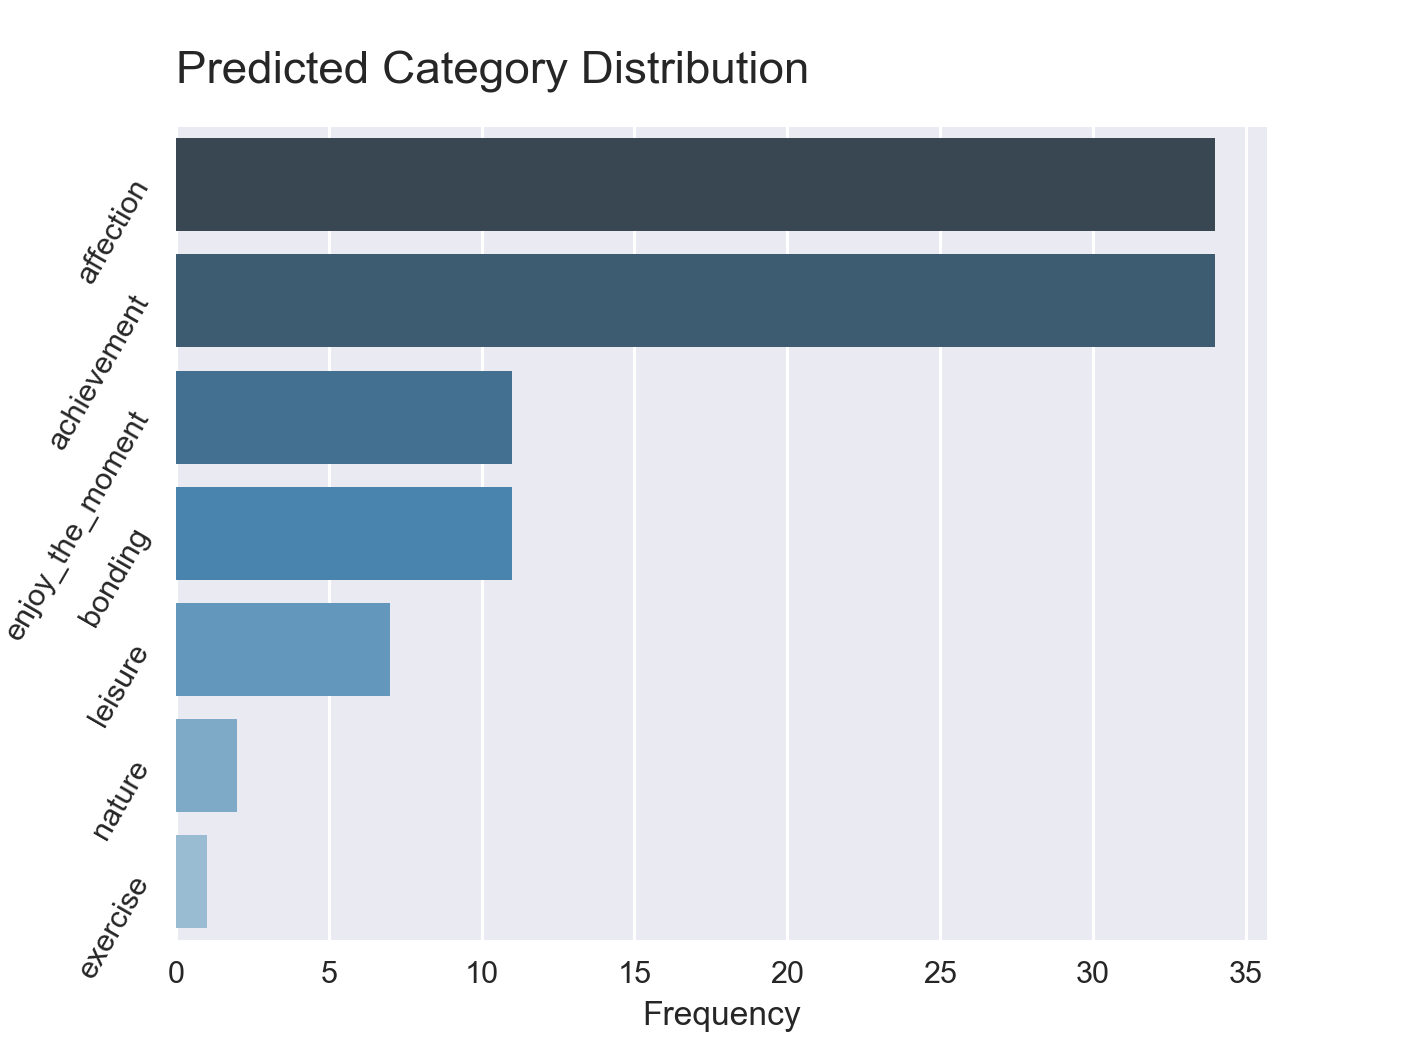

In [111]:
pc = 100*round((happy['predicted_category'].value_counts()/happy.shape[0]),2)
plt.figure()
ax = sns.barplot(pc,pc.index,palette="Blues_d")
ax.set_xlabel('Frequency')
ax.set_yticklabels(ax.get_yticklabels(),rotation = 60)
ax.set_ylabel('')
ax.set_title('Predicted Category Distribution',
             loc = 'left', fontsize = 15,y = 1.03);

    

From the plot, we can see affection and ahievement is two the most frequent class in predicted category, which means that when people talk about happiness, they would like to talk about affection and achievement.

### Does men and women experience happiness differently?

After doing some EDA, we can start to explore our goal -- study the different happiness between male and female.

First, I divide our dataset into training set and testing(validation) set, and set the seed(random_state) to be 0. Then I use Tf-IDF model and n-gram = (1,2) to tokenize,stem and lemmatizer the text. We also need to remove the stopwords, and remove tokens that don't appear in at least 20 documents, and remove tokens that appear in more than 20% of the documents.

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import nltk


In [113]:
X_train, X_test, y_train, y_test = train_test_split(happy['cleaned_hm'], 
                                                    happy['gender'], 
                                                    random_state=0);
# print('\n\nX_train shape: ', X_train.shape)

In [114]:
# Use Tf-IDF Model with ngram = (1,2)
# remove tokens that don't appear in at least 20 documents,
# remove tokens that appear in more than 20% of the documents
stopwords = nltk.corpus.stopwords.words('english')
stopword = ["happy","ago","yesterday","lot","today","months","month",
                 "happier","happiest","last","week","past","3mth"]
stopwords.extend(stopword)
vect = TfidfVectorizer(ngram_range = (1,2),min_df = 10,max_df = 0.2,stop_words = stopwords)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

In [115]:
def Grid_auc(model,grid_values):
    grid_NB_auc = GridSearchCV(model, param_grid = grid_values).fit(X_train_vect,y_train)
    print('Grid best parameter (max. AUC): ', grid_NB_auc.best_params_)
    print('Grid best score (AUC): ', grid_NB_auc.best_score_)
    
def print_male_female(model):
    feature_names = np.array(vect.get_feature_names())
    model_fit = model.fit(X_train_vect,y_train)
    coef_index = model_fit.coef_[0].argsort()
    Female = feature_names[coef_index[:10]].tolist()
    Male = feature_names[coef_index[-10:]].tolist()
    Male.reverse()
    prediction = model_fit.predict(X_test_vect)
    
    Female_importance = sorted(model_fit.coef_[0])[:10]
    Female_importance = [abs(elem) for elem in Female_importance]
    Female_importance = [round(elem,2) for elem in Female_importance]
    male_importance =  sorted(model_fit.coef_[0], reverse = True)[:10]
    male_importance = [round(elem,2) for elem in male_importance]
    
    print('TEST AUC is:',roc_auc_score(y_test,prediction))
    df1 = pd.DataFrame({'Key Words':Female,'Importance':Female_importance})
    df2 = pd.DataFrame({'Key Words':Male,'Importance':male_importance})
    return df1,df2

After finishing text preprocessing, I perform grid search for logistic regression to find best parameters, for here, I add C, also known as regularization strength, and penalty to grid search. 

As the result, we find C = 1 and penalty = l2 to be the best parameters.

In [116]:
grid_values = {'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100],'penalty':['l1','l2']}
LR = LogisticRegression()

Grid_auc(LR,grid_values)

Grid best parameter (max. AUC):  {'C': 1, 'penalty': 'l2'}
Grid best score (AUC):  0.6651815668697496


Next, Let's plot the feature importance for female and male.

TEST AUC is: 0.6557336318857807


<IPython.core.display.Javascript object>


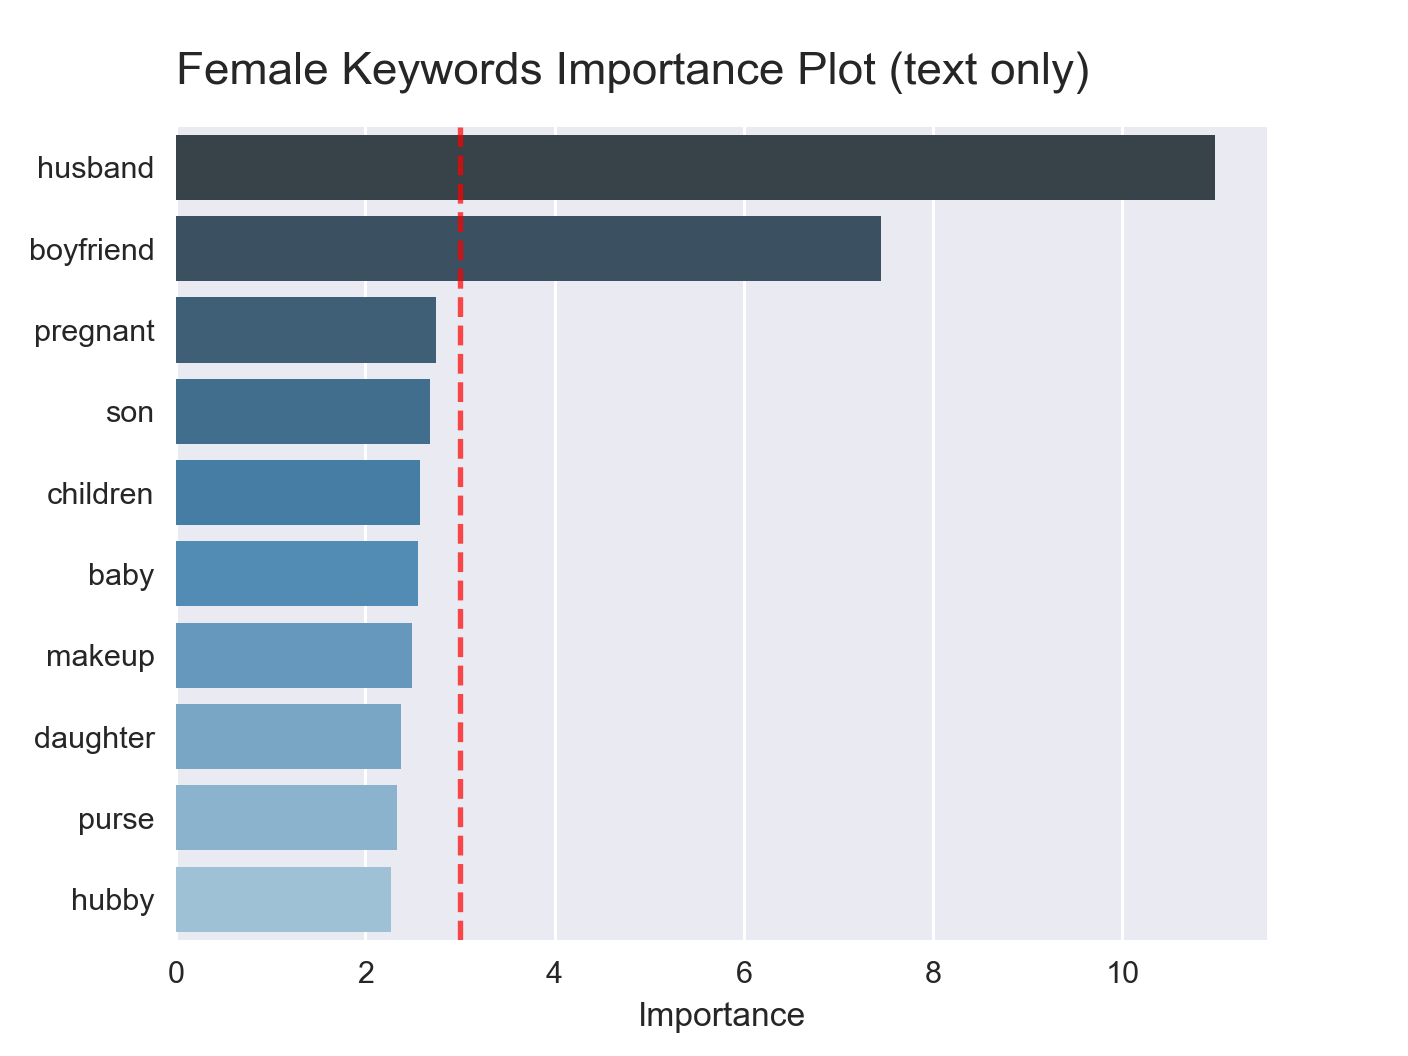

In [120]:
LR = LogisticRegression(C = 1, penalty = 'l2',class_weight = 'balanced')
Female,Male = print_male_female(LR)

plt.figure()
Female = Female.set_index('Key Words')
ax = sns.barplot(Female['Importance'],Female.index,palette="Blues_d")
ax.set_xlabel('Importance')
ax.set_yticklabels(ax.get_yticklabels())
ax.set_ylabel('')
ax.set_title('Female Keywords Importance Plot (text only)',
             loc = 'left', fontsize = 15,y = 1.03);
plt.axvline(3,color = 'red',linestyle='--',alpha = 0.7);

<IPython.core.display.Javascript object>


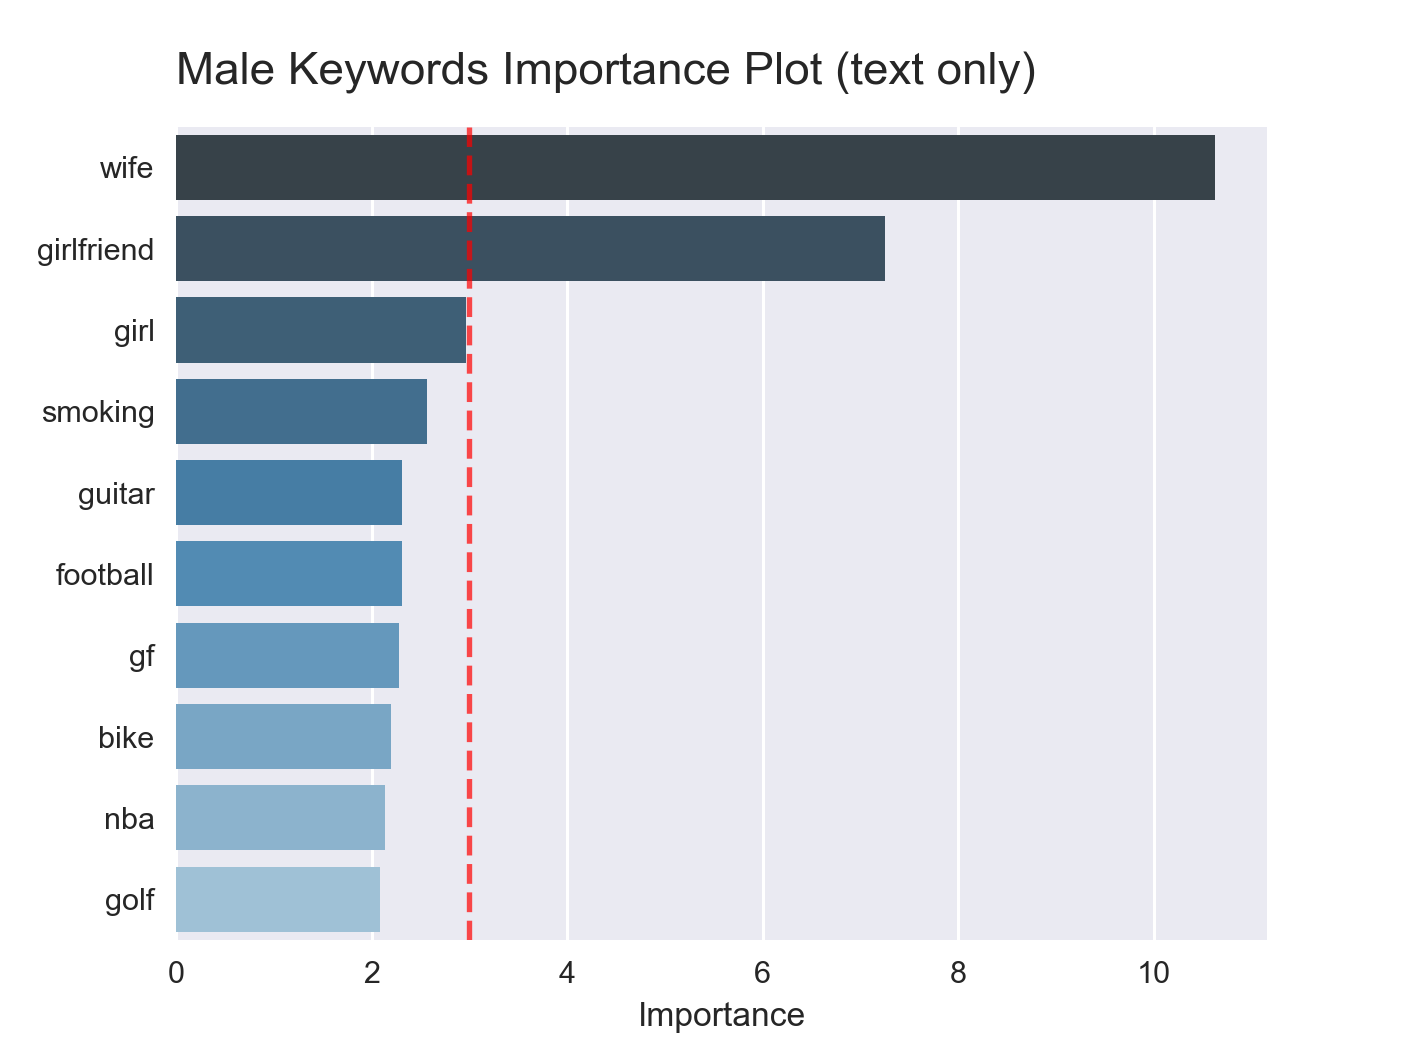

In [121]:
plt.figure()
Male = Male.set_index('Key Words')
ax = sns.barplot(Male['Importance'],Male.index,palette="Blues_d")
ax.set_xlabel('Importance')
ax.set_yticklabels(ax.get_yticklabels())
ax.set_ylabel('')
ax.set_title('Male Keywords Importance Plot (text only)',
             loc = 'left', fontsize = 15,y = 1.03);
plt.axvline(3,color = 'red',linestyle='--',alpha = 0.7);

From the result, we can see that:

- For female: **husband** and **boyfriend** are features that importance are more than 3, and these top key words are all about family. Then female also feel happy with **pregnant, son, children, baby, makeup, daughter, purse** and **hubby**.

- For male: There are only 3 key word have importance larger than or around 3 -- **wife, girlfriend and girl**. That was interesting because male not only feels happy about their wife or girlfriend, they also feel happy about other girl. Other key word is **bike, guitar, smoking, football, golf, nba and gf(a.k.a girlfriend)**. 

Reuslt: compared to other topics, more people, no matter male or female, feel happy when refering to family. However, for female, 8/10 is about family, and 4/10 for male. We can conclude that female would like to talk more about family then male, but both male and female are happiest about family.